### Import Necessary Libraries

In [1]:
import pickle
import gzip
from PIL import Image
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

### Load MNIST Data

In [2]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

In [3]:
Training_X = training_data[0]
Training_T = training_data[1]
Validation_X = validation_data[0]
Validation_T = validation_data[1]
Test_X = test_data[0]
Test_T = test_data[1]

n = Training_X.shape[0] #Number of Training Data Points
m = Training_X.shape[1] #Number of Training Features
k = 10 # Number of target classes

#Convert Training Targets into Hot Vectors
temp = np.zeros((Training_T.shape[0],k))
temp[np.arange(Training_T.shape[0]),Training_T] = 1
H_Training_T = temp

#Convert Validation Targets into Hot Vectors
temp = np.zeros((Validation_T.shape[0],k))
temp[np.arange(Validation_T.shape[0]),Validation_T] = 1
H_Validation_T = temp

#Convert Test Targets into Hot Vectors
temp = np.zeros((Test_T.shape[0],k))
temp[np.arange(Test_T.shape[0]),Test_T] = 1
H_Test_T = temp

#Adding Bias to Training, Validation and Test Data
if Training_X.shape[1] == m:
    Training_X = np.insert(Training_X, 0, 1, axis=1) #1 is bias term
    Validation_X = np.insert(Validation_X, 0, 1, axis=1) #1 is bias term
    Test_X = np.insert(Test_X, 0, 1, axis=1) #1 is bias term

print(Training_X.shape, H_Training_T.shape, Training_T.shape)
print(Validation_X.shape, H_Validation_T.shape, Validation_T.shape)
print(Test_X.shape, H_Test_T.shape, Test_T.shape)

(50000, 785) (50000, 10) (50000,)
(10000, 785) (10000, 10) (10000,)
(10000, 785) (10000, 10) (10000,)


### Load USPS Data

In [4]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/USPSdata/Numerals'
#curPath  = 'USPSdata/USPSdata/Test'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    #curFolderPath = curPath
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [5]:
USPSMat = np.array(USPSMat)
USPSTar = np.array(USPSTar)

#Adding Bias to Training, Validation and Test Data
if USPSMat.shape[1] == m: 
    USPSMat = np.insert(USPSMat, 0, 1, axis=1) #1 is bias term

#Convert Test Targets into Hot Vectors
temp = np.zeros((USPSTar.shape[0],k))
temp[np.arange(USPSTar.shape[0]) ,USPSTar] = 1
H_USPSTar = temp

print(USPSMat.shape, H_USPSTar.shape, USPSTar.shape)

(19999, 785) (19999, 10) (19999,)


### Softmax Function

In [6]:
def softmax(z):
    t = np.exp(z)
    a = np.exp(z) / np.sum(t, axis=1).reshape(-1,1)
    return a

### Cost Function

In [7]:
def cost(w, x, y):
    w = np.matrix(w)
    x = np.matrix(x)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(softmax(x * w)))
    second = np.multiply((1 - y), np.log(1 - softmax(x * w)))
    return np.sum(first - second) / (len(x))

### Compute Gradient

In [8]:
def gradient(w, x, t): #Weights, Training Data & Training Tergets
    w = np.matrix(w, dtype = np.float128)
    x = np.matrix(x, dtype = np.float128)
    t = np.matrix(t, dtype = np.float128)
    error = softmax(x * w) - t #Calculate nxk Error Matrix
    grad = error.T * x
    return grad

### Softmax Regression using Gradient Descent

In [21]:
start_time = time.time()

#Initialize weight vector
#W_Now = np.random.rand(k,m)
W_Now = np.zeros((k,m))
W_Now = np.insert(W_Now, 0, 0.1, axis=1) #0.1 is bias weight term
#print(W_Now.T.shape)
learningRate = 0.001
la = 2
TrainAcc = []
ValAcc = []

for i in range(0,200): #Num of Epochs
    #print("Epoch= "+str(i))
    #print("Loss for " +str(i)+ "Epoch: " +str(cost(W_Now.T, Training_X, H_Training_T)))
    delta_W = gradient(W_Now.T, Training_X, H_Training_T) # KxM Matrix returned
    W_Next = W_Now - (np.dot(learningRate, delta_W))
    W_Now = W_Next
    
    Y_Train = softmax(np.matmul(Training_X, W_Now.T))
    Y_Train_Argmax = np.array([np.argmax(Y_Train[i]) for i in range(0,len(Y_Train))])
    diff = np.subtract(Y_Train_Argmax, Training_T)
    non_zeros = np.count_nonzero(diff)
    accuracy = ((len(diff) - non_zeros)/len(diff))*100
    TrainAcc.append(accuracy)
    
    Y_Val = softmax(np.matmul(Validation_X, W_Now.T))
    Y_Val_Argmax = np.array([np.argmax(Y_Val[i]) for i in range(0,len(Y_Val))])
    diff = np.subtract(Y_Val_Argmax, Validation_T)
    non_zeros = np.count_nonzero(diff)
    accuracy = ((len(diff) - non_zeros)/len(diff))*100
    ValAcc.append(accuracy)

#Computation of Testing Accuracy on MNIST Data
Y_Test = softmax(np.matmul(Test_X, W_Now.T))
Y_SF_MNIST = np.array([np.argmax(Y_Test[i]) for i in range(0,len(Y_Test))]) #Predicted Y for Mnist by Softmax
m_diff = np.subtract(Y_SF_MNIST, Test_T)
m_non_zeros = np.count_nonzero(m_diff)
mnist_accuracy = ((len(m_diff) - m_non_zeros)/len(m_diff))*100

#Computation of Testing Accuracy on USPS Data
Y_Test = softmax(np.matmul(USPSMat, W_Now.T))
Y_SF_USPS = np.array([np.argmax(Y_Test[i]) for i in range(0,len(Y_Test))]) #Predicted Y for USPS by Softmax
u_diff = np.subtract(Y_SF_USPS, USPSTar)
u_non_zeros = np.count_nonzero(u_diff)
usps_accuracy = ((len(u_diff) - u_non_zeros)/len(u_diff))*100

print("\n--- %s seconds ---" % (time.time() - start_time))


--- 4087.6492953300476 seconds ---


### Observations

In [22]:
print ('UBITname      = animeshp')
print ('Person Number = 50290441')
print ('----------------------------------------------------')
print ('Softmax Regression Using Gradient Descent Solution-')
print ('----------------------------------------------------')
print ('----------------------------------------------------')
print ("Regularizer = "+str(la)+"\nLearning Rate = "+str(learningRate))
print ("Training Accuracy = " + str(np.around(max(TrainAcc),5))+"%")
print ("Validation Accuracy = " + str(np.around(max(ValAcc),5))+"%")

print("\nMNIST Data Observation Below:")
print("Errors: " + str(m_non_zeros), " Correct :" + str(len(m_diff) - m_non_zeros))
print ("Testing Accuracy = "+str(np.around(mnist_accuracy, 5))+"%")
Conf_SF_MNIST = confusion_matrix(Test_T, Y_SF_MNIST)
print("\nMNIST Data Confusion Matrix\n")
print(Conf_SF_MNIST)

print("\nUSPS Data Observation Below:")
print("Errors: " + str(u_non_zeros), " Correct :" + str(len(u_diff) - u_non_zeros))
print ("Testing Accuracy = "+str(np.around(usps_accuracy, 5))+"%")
Conf_SF_USPS = confusion_matrix(USPSTar, Y_SF_USPS)
print("\nUSPS Data Confusion Matrix\n")
print(Conf_SF_USPS)
print("\nSupports No Free Lunch Theorem")

UBITname      = animeshp
Person Number = 50290441
----------------------------------------------------
Softmax Regression Using Gradient Descent Solution-
----------------------------------------------------
----------------------------------------------------
Regularizer = 2
Learning Rate = 0.001
Training Accuracy = 91.436%
Validation Accuracy = 92.0%

MNIST Data Observation Below:
Errors: 866  Correct :9134
Testing Accuracy = 91.34%

MNIST Data Confusion Matrix

[[ 947    0    4    3    0   16    6    3    1    0]
 [   0 1113    5    3    0    5    3    1    5    0]
 [   5   10  937   16   11    5    9   12   20    7]
 [   3    1   24  917    0   36    1    9    9   10]
 [   1    3    6    3  900    2   12    3    6   46]
 [   7    1    7   29    9  789   12    6   25    7]
 [  12    2    8    2   12   21  895    4    2    0]
 [   2    8   26   11    6    2    0  939    0   34]
 [   7   11   14   41   12   52   10   14  805    8]
 [  10    5    2   12   38   15    0   29    6  892]]


### Neural Network Implementation using Keras

In [23]:
import keras
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras import utils as np_utils
from keras import optimizers

input_size = Training_X.shape[1]
drop_out = 0.2                                                                                                                                                                                                                                                                                                                                      
first_dense_layer_nodes  = 256
second_dense_layer_nodes = 64
output_layer_nodes = k

def get_model():
    
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size, activation='relu'))   
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes, activation='tanh'))
    #model.add(Dropout(drop_out))
    
    model.add(Dense(output_layer_nodes, activation='softmax'))
    
    keras.optimizers.rmsprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.summary()
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

Using TensorFlow backend.


In [24]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               201216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 218,314
Trainable params: 218,314
Non-trainable params: 0
_________________________________________________________________


### Run Neural Network Model

In [25]:
validation_data_split = 0.20 # 20% of the training data is reserved as Validation Dataset.
num_epochs = 10000 # One complete learning of the training data is called an Epoch. 
model_batch_size = 128 # Number of data samples in each batch
tb_batch_size = 32 
early_patience = 10 #Number of epochs with no improvement after which training is stopped. Here Gradient descent is used to 
# determine the point of local minima where the derivative of the plot equalls zero.  

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

concatenated_data = np.concatenate((Training_X, Validation_X), axis=0)
concatenated_targets = np.concatenate((H_Training_T, H_Validation_T), axis=0)

#concatenated_targets = np_utils.to_categorical(np.array(concatenated_targets),2)
# Process Dataset 
history = model.fit(concatenated_data
                    , concatenated_targets                         # Training occurs here
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb, earlystopping_cb]
                   )

Train on 48000 samples, validate on 12000 samples
Epoch 1/10000
48000/48000 [==============================] - 4s 92us/step - loss: 0.3143 - acc: 0.9081 - val_loss: 0.1499 - val_acc: 0.9552
Epoch 2/10000
48000/48000 [==============================] - 4s 77us/step - loss: 0.1339 - acc: 0.9589 - val_loss: 0.1079 - val_acc: 0.9668
Epoch 3/10000
48000/48000 [==============================] - 4s 94us/step - loss: 0.0928 - acc: 0.9718 - val_loss: 0.0870 - val_acc: 0.9736
Epoch 4/10000
48000/48000 [==============================] - 5s 110us/step - loss: 0.0722 - acc: 0.9774 - val_loss: 0.0869 - val_acc: 0.9741
Epoch 5/10000
48000/48000 [==============================] - 5s 106us/step - loss: 0.0624 - acc: 0.9811 - val_loss: 0.0752 - val_acc: 0.9775
Epoch 6/10000
48000/48000 [==============================] - 5s 104us/step - loss: 0.0514 - acc: 0.9840 - val_loss: 0.0778 - val_acc: 0.9773
Epoch 7/10000
48000/48000 [==============================] - 4s 82us/step - loss: 0.0439 - acc: 0.9862 - va

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e4060c198>,
      dtype=object)

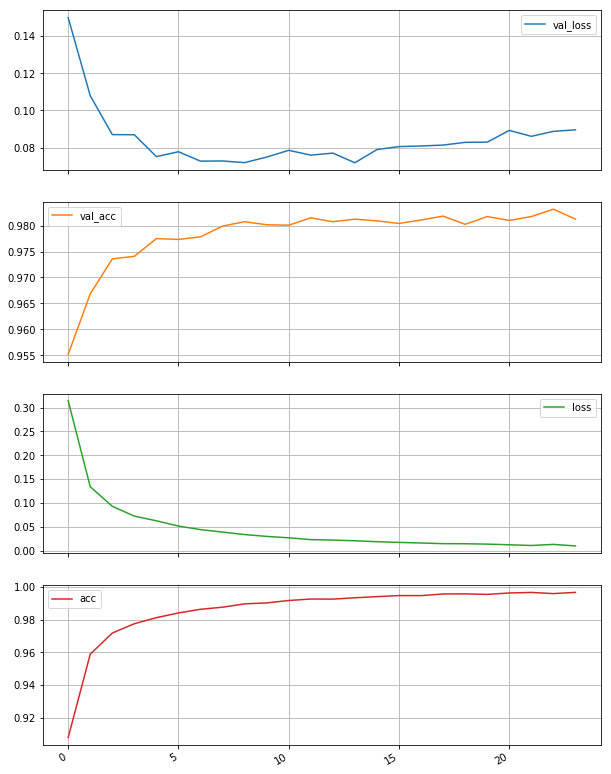

In [26]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [27]:
wrong   = 0
right   = 0
Y_KNN_MNIST = []
Y_KNN_USPS = []

#TestDataAct = np_utils.to_categorical(np.array(TestDataAct),2)

print("-----Observations on MNIST Data-----")

for i,j in zip(Test_X, H_Test_T):
    y = model.predict(np.array(i).reshape(-1,Test_X.shape[1])) # Here the model predicts classes of the test data.
    Y_KNN_MNIST.append(y.argmax())
    if j.argmax() == y.argmax():
        right = right + 1 # Count Matches between predicted and processed values (Software 1.0 and 2.0) 
    else:
        wrong = wrong + 1 # Count Mismatches


print("Errors: " + str(wrong), " Correct :" + str(right))

print("MNIST Data Testing Accuracy: " + str(np.around(right/(right+wrong)*100, 5)))
Conf_KNN_MNIST = confusion_matrix(Test_T, Y_KNN_MNIST)
print("\nMNIST Data Confusion Matrix\n")
print(Conf_KNN_MNIST)

print("\n-----Observations on USPS Data-----")

for i,j in zip(USPSMat, H_USPSTar):
    y = model.predict(np.array(i).reshape(-1,USPSMat.shape[1])) # Here the model predicts classes of the test data.
    Y_KNN_USPS.append(y.argmax())
    if j.argmax() == y.argmax():
        right = right + 1 # Count Matches between predicted and processed values (Software 1.0 and 2.0) 
    else:
        wrong = wrong + 1 # Count Mismatches

print("Errors: " + str(wrong), " Correct :" + str(right))

print("USPS Data Testing Accuracy: " + str(np.around(right/(right+wrong)*100, 5)))
Conf_KNN_USPS = confusion_matrix(USPSTar, Y_KNN_USPS)
print("\nUSPS Data Confusion Matrix\n")
print(Conf_KNN_USPS)
print("\nSupports No Free Lunch Theorem")

-----Observations on MNIST Data-----
Errors: 180  Correct :9820
MNIST Data Testing Accuracy: 98.2

MNIST Data Confusion Matrix

[[ 972    1    0    0    0    1    3    1    1    1]
 [   0 1126    2    1    0    1    1    0    4    0]
 [   5    1 1009    2    2    0    3    5    5    0]
 [   0    1    2  991    0    6    0    3    5    2]
 [   1    1    2    1  965    0    4    2    1    5]
 [   2    0    0    3    1  875    6    2    2    1]
 [   1    2    0    1    5    2  944    0    3    0]
 [   0    6    8    5    1    0    0  998    5    5]
 [   2    0    2    2    3    2    1    1  957    4]
 [   1    3    0    1   15    3    0    1    2  983]]

-----Observations on USPS Data-----
Errors: 11547  Correct :18452
USPS Data Testing Accuracy: 61.50872

USPS Data Confusion Matrix

[[ 549    3  224   28  168  150  437  122   99  220]
 [  27  404  533   86  475   74   31  113  157  100]
 [  58   12 1549   39   25   82  140   39   51    4]
 [  27    6  460 1091   11  284   46   15   38   

### Neural Network Implementation using Scikit Learns  

In [28]:
start_time = time.time()
scaler = StandardScaler()

#scaler.fit(Training_X)
Train_X = scaler.fit_transform(Training_X)
Tst_X = scaler.fit_transform(Test_X)
USPS_X = scaler.fit_transform(USPSMat)

model_NN = MLPClassifier(hidden_layer_sizes= (256, 64), max_iter=1000)
model_NN.fit(Train_X, Training_T.ravel())

Y_SNN_MNIST = model_NN.predict(Tst_X)
Conf_SNN_MNIST = confusion_matrix(Test_T, Y_SNN_MNIST)

Y_SNN_USPS = model_NN.predict(USPS_X)
Conf_SNN_USPS = confusion_matrix(USPSTar, Y_SNN_USPS)

print("\nAccuracy on MNIST Data = "+ str(np.around(accuracy_score(Test_T, Y_SNN_MNIST)*100, 3))+"%")
print("\nMNIST Data Confusion Matrix\n")
print(Conf_SNN_MNIST)
print("\nAccuracy on USPS Data = "+ str(np.around(accuracy_score(USPSTar, Y_SNN_USPS)*100, 3))+"%")
print("\nUSPS Data Confusion Matrix\n")
print(Conf_SNN_USPS)
print("\nSupports No Free Lunch Theorem")

print("\n--- %s seconds ---" % (time.time() - start_time))


Accuracy on MNIST Data = 97.86%

MNIST Data Confusion Matrix

[[ 970    1    0    1    1    1    3    1    2    0]
 [   0 1128    2    0    0    1    2    1    1    0]
 [   3    2 1010    0    3    1    2    6    5    0]
 [   0    0    5  986    0    7    0    4    5    3]
 [   0    0    6    2  956    0    2    1    2   13]
 [   1    0    0    9    1  867    6    1    5    2]
 [   4    2    2    1    4    4  941    0    0    0]
 [   1    6    5    3    0    0    0 1001    4    8]
 [   2    1    1    7    6    2    1    5  945    4]
 [   3    2    1    6    8    2    0    3    2  982]]

Accuracy on USPS Data = 42.497%

USPS Data Confusion Matrix

[[ 446    8  160   89  160  158  271  177  154  377]
 [  25  191  304  297  120   86   31  129  590  227]
 [  26   24 1319  148   19  109  114   40  181   19]
 [  11   14  145 1425    0  216   16   22  125   26]
 [   4   65   69   58  946   69   41  183  420  145]
 [  32    7  155  155    7 1284   92   27  228   13]
 [  81   19  301   43   45

### SVM Implementation using Linear Kernel

In [29]:
start_time = time.time()

#Linear Kernel with all other Parameters kept Default
model_SVM1 = SVC(kernel='linear')
model_SVM1.fit(Training_X, Training_T)

Y_LSVM_MNIST = model_SVM1.predict(Test_X)
Conf_LSVM_MNIST = confusion_matrix(Test_T, Y_LSVM_MNIST)

Y_LSVM_USPS = model_SVM1.predict(USPSMat)
Conf_LSVM_USPS = confusion_matrix(USPSTar, Y_LSVM_USPS)

print("\nAccuracy on Linear Kernel on MNIST Data = "+ str(np.around(accuracy_score(Test_T, Y_LSVM_MNIST)*100, 3))+"%")
print("\nMNIST Data Confusion Matrix\n")
print(Conf_LSVM_MNIST)
print("\nAccuracy on Linear Kernel on USPS Data = "+ str(np.around(accuracy_score(USPSTar, Y_LSVM_USPS)*100, 3))+"%")
print("\nUSPS Data Confusion Matrix\n")
print(Conf_LSVM_USPS)
print("\nSupports No Free Lunch Theorem")

print("\n--- %s seconds ---" % (time.time() - start_time))


Accuracy on Linear Kernel on MNIST Data = 93.9%

MNIST Data Confusion Matrix

[[ 959    0    5    2    2    4    7    0    1    0]
 [   0 1121    3    3    0    1    2    1    4    0]
 [   6    8  968    9    3    2   11   10   13    2]
 [   5    2   17  944    4   13    1    8   13    3]
 [   2    1   10    1  943    0    4    2    2   17]
 [  13    4    2   39    5  792    9    1   22    5]
 [  10    3   11    1    5   14  911    2    1    0]
 [   1    8   20   10    6    1    0  961    3   18]
 [   8    4    9   25   11   27    6    5  871    8]
 [   7    6    2   13   32    4    0   18    7  920]]

Accuracy on Linear Kernel on USPS Data = 29.126%

USPS Data Confusion Matrix

[[ 348    0  476  152  222  345   74  172   10  201]
 [  60  303  534  275  230  172   17  351   37   21]
 [ 139   63 1293  115   33  221   55   45   21   14]
 [  56   58  341  898    8  520    9   45   48   17]
 [  24   24  221   82  800  215   10  464   82   78]
 [  47   25  652  240   41  876   30   35   41

### SVM Implementation using RBF Kernel

In [30]:
#RBF Kernel with all other Parameters kept Default
start_time = time.time()

model_SVM3 = SVC(kernel='rbf', gamma='auto')
model_SVM3.fit(Training_X, Training_T)

Y_RSVM_MNIST = model_SVM3.predict(Test_X)
Conf_RSVM_MNIST = confusion_matrix(Test_T, Y_RSVM_MNIST)

Y_RSVM_USPS = model_SVM3.predict(USPSMat)
Conf_RSVM_USPS = confusion_matrix(USPSTar, Y_RSVM_USPS)

print("\nAccuracy on RBF Kernel on MNIST Data = "+ str(np.around(accuracy_score(Test_T, Y_RSVM_MNIST)*100, 3))+"%")
print("\nMNIST Data Confusion Matrix\n")
print(Conf_RSVM_MNIST)
print("\nAccuracy on RBF Kernel on USPS Data = "+ str(np.around(accuracy_score(USPSTar, Y_RSVM_USPS)*100, 3))+"%")
print("\nUSPS Data Confusion Matrix\n")
print(Conf_RSVM_USPS)
print("\nSupports No Free Lunch Theorem")

print("\n--- %s seconds ---" % (time.time() - start_time))


Accuracy on RBF Kernel on MNIST Data = 94.35%

MNIST Data Confusion Matrix

[[ 967    0    1    0    0    5    4    1    2    0]
 [   0 1120    2    3    0    1    3    1    5    0]
 [   9    1  962    7   10    1   13   11   16    2]
 [   1    1   14  950    1   17    1   10   11    4]
 [   1    1    7    0  937    0    7    2    2   25]
 [   7    4    5   33    7  808   11    2   10    5]
 [  10    3    4    1    5   10  924    0    1    0]
 [   2   13   22    5    7    1    0  954    4   20]
 [   4    6    6   14    8   24   10    8  891    3]
 [  10    6    0   12   33    5    1   14    6  922]]

Accuracy on RBF Kernel on USPS Data = 38.532%

USPS Data Confusion Matrix

[[ 573    2  428   19  285  248   73   44    6  322]
 [ 110  429  285  137  273  180   46  501   22   17]
 [ 128   18 1401   59   39  198   62   57   23   14]
 [  76    3  185 1123   11  483    5   71   27   16]
 [  18   67   91   13 1167  267   22  194   69   92]
 [ 108   17  257  102   25 1366   60   43   16    6

### Implementation of Random Forest Classifier

In [55]:
start_time = time.time()

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(Training_X, Training_T)

Y_RF_MINST = model_RF.predict(Test_X)
Conf_RF_MNIST = confusion_matrix(Test_T, Y_RF_MINST)

Y_RF_USPS = model_RF.predict(USPSMat)
Conf_RF_USPS = confusion_matrix(USPSTar, Y_RF_USPS)

print("\nAccuracy on MNIST Data = "+ str(np.around(accuracy_score(Test_T, Y_RF_MINST)*100, 3))+"%")
print("\nMNIST Data Confusion Matrix\n")
print(Conf_RF_MNIST)
print("\nAccuracy on USPS Data = "+ str(np.around(accuracy_score(USPSTar, Y_RF_USPS)*100, 3))+"%")
print("\nUSPS Data Confusion Matrix\n")
print(Conf_RF_USPS)
print("\nSupports No Free Lunch Theorem")
print("\n--- %s seconds ---" % (time.time() - start_time))


Accuracy on MNIST Data = 96.82%

MNIST Data Confusion Matrix

[[ 970    0    0    1    0    4    2    1    2    0]
 [   0 1122    3    3    0    2    2    1    2    0]
 [   5    0 1002    4    2    0    4    9    5    1]
 [   1    0   10  972    0    8    0    9    8    2]
 [   2    0    2    0  953    0    6    1    2   16]
 [   2    1    0   13    1  858    7    2    5    3]
 [   6    3    0    0    4    3  937    0    5    0]
 [   1    5   20    1    1    0    0  988    2   10]
 [   4    0    5    9    6    6    6    4  925    9]
 [   6    5    1   12   13    2    1    5    9  955]]

Accuracy on USPS Data = 38.867%

USPS Data Confusion Matrix

[[ 626   10  254   60  428  140   81  123    4  274]
 [  48  549  120  123   65   78   29  974   14    0]
 [ 120   36 1197   95   52  190   31  270    5    3]
 [  46   10  103 1305   47  305    1  160    4   19]
 [  11  208   54   32 1038  169   19  415   30   24]
 [ 153   23  159  128   24 1344   43  110    6   10]
 [ 331   50  222   34   95

Text(0.5, 0, 'Number of Decision Trees')

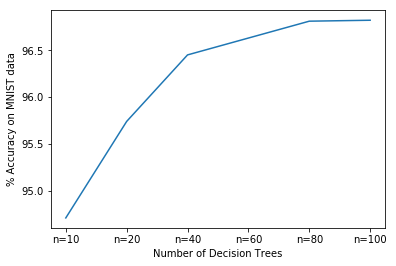

In [59]:
%matplotlib inline
l = [94.71, 95.74, 96.45, 96.63, 96.81, 96.82]
a = ['n=10','n=20','n=40','n=60','n=80','n=100']
plt.plot(a,l)
plt.ylabel('% Accuracy on MNIST data')
plt.xlabel('Number of Decision Trees')

Text(0.5, 0, 'Number of Decision Trees')

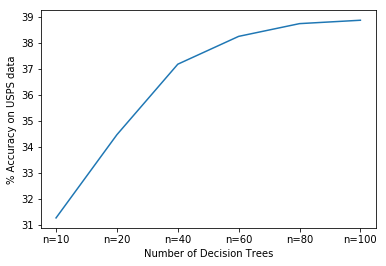

In [60]:
%matplotlib inline
l = [31.26, 34.46, 37.17, 38.24, 38.73, 38.86]
a = ['n=10','n=20','n=40','n=60','n=80','n=100']
plt.plot(a,l)
plt.ylabel('% Accuracy on USPS data')
plt.xlabel('Number of Decision Trees')

### Mini Batch Stochastic Gradient Descent

In [44]:
start_time = time.time()

#Initialize weight vector
#W_Now = np.random.rand(k,m)
W_Now = np.zeros((k,m))
W_Now = np.insert(W_Now, 0, 0.1, axis=1) #0.1 is bias weight term
learningRate = 0.001
la = 2
c = 10 #Number of Chunks.
TrainAcc = []
ValAcc = []
data_partitions = np.zeros(c)
target_partitions = np.zeros(c)

Training_data = np.concatenate((Training_X, H_Training_T), axis=1)

for i in range(0,7): #Num of Epochs
    np.random.shuffle(Training_data) #Shuffle Training Dataset Rowwise
    data = Training_data[:,:int(m+1)] #Slice Data only
    target = Training_data[:,int(m+1):int(m+1+k)] #Slice Targets only
    data_partitions = np.split(data, c) #Split data into 20 chunks
    target_partitions = np.split(target, c) #Split targets into corresponding c chunks
    
    for j in range(0,c): #Num of Chunks
        #print("Epoch= "+str(i+1)+" Chunk= "+str(j+1))
        #print("Loss for " +str(i+1)+" Epoch and "+str(j+1)+" Chunk: " +str(cost(W_Now.T, Training_X, H_Training_T)))
        delta_W = gradient(W_Now.T, data_partitions[j], target_partitions[j]) # KxM Matrix returned
        W_Next = W_Now - (np.dot(learningRate, delta_W))
        W_Now = W_Next

        Y_Train = softmax(np.matmul(Training_X, W_Now.T))
        Y_Train_Argmax = np.array([np.argmax(Y_Train[i]) for i in range(0,len(Y_Train))])
        diff = np.subtract(Y_Train_Argmax, Training_T)
        non_zeros = np.count_nonzero(diff)
        accuracy = ((len(diff) - non_zeros)/len(diff))*100
        TrainAcc.append(accuracy)

        Y_Val = softmax(np.matmul(Validation_X, W_Now.T))
        Y_Val_Argmax = np.array([np.argmax(Y_Val[i]) for i in range(0,len(Y_Val))])
        diff = np.subtract(Y_Val_Argmax, Validation_T)
        non_zeros = np.count_nonzero(diff)
        accuracy = ((len(diff) - non_zeros)/len(diff))*100
        ValAcc.append(accuracy)

#Computation of Testing Accuracy on MNIST Data
Y_Test = softmax(np.matmul(Test_X, W_Now.T))
Y_MSF_MNIST = np.array([np.argmax(Y_Test[i]) for i in range(0,len(Y_Test))]) #Predicted Y for Mnist by Softmax
m_diff = np.subtract(Y_MSF_MNIST, Test_T)
m_non_zeros = np.count_nonzero(m_diff)
mnist_accuracy = ((len(m_diff) - m_non_zeros)/len(m_diff))*100

#Computation of Testing Accuracy on USPS Data
Y_Test = softmax(np.matmul(USPSMat, W_Now.T))
Y_MSF_USPS = np.array([np.argmax(Y_Test[i]) for i in range(0,len(Y_Test))]) #Predicted Y for USPS by Softmax
u_diff = np.subtract(Y_MSF_USPS, USPSTar)
u_non_zeros = np.count_nonzero(u_diff)
usps_accuracy = ((len(u_diff) - u_non_zeros)/len(u_diff))*100

print("\n--- %s seconds ---" % (time.time() - start_time))


--- 321.53772735595703 seconds ---


### Results

In [45]:
print ('UBITname      = animeshp')
print ('Person Number = 50290441')
print ('----------------------------------------------------')
print ('Softmax Regression Using Mini Batch Gradient Descent Solution-')
print ('----------------------------------------------------')
print ('----------------------------------------------------')
print ("Regularizer = "+str(la)+"\nLearning Rate = "+str(learningRate))
print ("Training Accuracy = " + str(np.around(max(TrainAcc),5))+"%")
print ("Validation Accuracy = " + str(np.around(max(ValAcc),5))+"%")

print("\nMNIST Data Observation Below:")
print("Errors: " + str(m_non_zeros), " Correct :" + str(len(m_diff) - m_non_zeros))
print ("Testing Accuracy = "+str(np.around(mnist_accuracy, 5))+"%")
Conf_MSF_MNIST = confusion_matrix(Test_T, Y_MSF_MNIST)
print("\nMNIST Data Confusion Matrix\n")
print(Conf_MSF_MNIST)

print("\nUSPS Data Observation Below:")
print("Errors: " + str(u_non_zeros), " Correct :" + str(len(u_diff) - u_non_zeros))
print ("Testing Accuracy = "+str(np.around(usps_accuracy, 5))+"%")
Conf_MSF_USPS = confusion_matrix(USPSTar, Y_MSF_USPS)
print("\nUSPS Data Confusion Matrix\n")
print(Conf_MSF_USPS)
print("\nSupports No Free Lunch Theorem")

UBITname      = animeshp
Person Number = 50290441
----------------------------------------------------
Softmax Regression Using Gradient Descent Solution-
----------------------------------------------------
----------------------------------------------------
Regularizer = 2
Learning Rate = 0.001
Training Accuracy = 89.642%
Validation Accuracy = 90.78%

MNIST Data Observation Below:
Errors: 957  Correct :9043
Testing Accuracy = 90.43%

MNIST Data Confusion Matrix

[[ 936    0    7    4    0   20   10    2    1    0]
 [   0 1108    5    4    0    4    4    1    9    0]
 [   7    4  927   14   11    3   11   18   29    8]
 [   3    0   22  909    0   47    3   10    6   10]
 [   2    3    7    2  887    1   21    3    8   48]
 [   7    2   12   31    6  785   13    6   20   10]
 [  13    3    9    3   11   22  895    1    1    0]
 [   3   10   32    8    7    0    1  927    1   39]
 [   7   10   18   58   10   45   17   20  778   11]
 [  11    6   11   16   31   16    0   25    2  891]]

Text(0.5, 0, 'Number of Epochs at C=10')

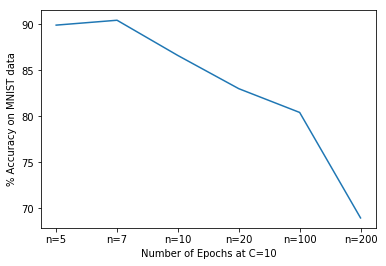

In [50]:
%matplotlib inline
l = [89.9, 90.43, 86.6, 83.0, 80.42, 68.97]
a = ['n=5','n=7','n=10','n=20','n=100','n=200']
plt.plot(a,l)
plt.ylabel('% Accuracy on MNIST data')
plt.xlabel('Number of Epochs at C=10')

### Ensemble Classifier using Majority Voting

In [61]:
start_time = time.time()

len_of_mnist = Test_T.shape[0]
len_of_usps = USPSTar.shape[0]

Y_ensemble_MNIST = np.zeros(len_of_mnist)
Y_ensemble_USPS = np.zeros(len_of_usps)

for i in range(0,len_of_mnist): #Set of Classes for Data point i. Total 6 Classifiers
    temp = np.array([Y_SF_MNIST[i], Y_KNN_MNIST[i], Y_SNN_MNIST[i], Y_LSVM_MNIST[i], Y_RSVM_MNIST[i], Y_RF_MINST[i], Y_MSF_MNIST[i]])
    counts = np.bincount(temp)
    Y_ensemble_MNIST[i] = np.argmax(counts) # Will Consider the first Mode Only
    #Predicted Y Values of Softmax R,NN,SVM,RF 

for i in range(0,len_of_usps):
    temp = np.array([Y_SF_USPS[i], Y_KNN_USPS[i], Y_SNN_USPS[i], Y_LSVM_USPS[i], Y_RSVM_USPS[i], Y_RF_USPS[i], Y_MSF_USPS[i]])
    counts = np.bincount(temp)
    Y_ensemble_USPS[i] = np.argmax(counts) # Will Consider the first Mode Only
    #Predicted Y Values of Softmax R,NN,SVM,RF
    
Conf_Ensemble_MNIST = confusion_matrix(Test_T, Y_ensemble_MNIST)
Conf_Ensemble_USPS = confusion_matrix(USPSTar, Y_ensemble_USPS)

print("\nAccuracy on MNIST Data = "+ str(np.around(accuracy_score(Test_T, Y_ensemble_MNIST)*100, 3))+"%")
print("\nMNIST Data Confusion Matrix\n")
print(Conf_Ensemble_MNIST)
print("\nAccuracy on USPS Data = "+ str(np.around(accuracy_score(USPSTar, Y_ensemble_USPS)*100, 3))+"%")
print("\nUSPS Data Confusion Matrix\n")
print(Conf_Ensemble_USPS)
print("\nSupports No Free Lunch Theorem")
print("\n--- %s seconds ---" % (time.time() - start_time))


Accuracy on MNIST Data = 96.17%

MNIST Data Confusion Matrix

[[ 972    0    1    1    0    2    2    1    1    0]
 [   0 1123    2    3    0    1    2    1    3    0]
 [   8    1  992    3    3    1    6    9    8    1]
 [   0    0   11  974    0    9    0    7    6    3]
 [   1    0    5    1  954    0    4    1    2   14]
 [   6    1    2   18    3  841    9    1    7    4]
 [   7    3    2    1    3    9  932    0    1    0]
 [   2    9   19    3    2    0    0  983    0   10]
 [   4    3    6   14    8   17    7    7  903    5]
 [   9    6    1   12   20    6    0    8    4  943]]

Accuracy on USPS Data = 39.757%

USPS Data Confusion Matrix

[[ 572    2  376   64  257  223   81   79   37  309]
 [ 101  409  311  273  191  138   20  448   94   15]
 [ 114   12 1480   90   29  146   40   59   18   11]
 [  51    3  197 1336    2  334    4   43   18   12]
 [  19   84   84   40 1109  183   20  213  163   85]
 [  79    9  279  125   19 1368   49   45   20    7]
 [ 172   10  508   43   65

Text(0.5, 0, 'Classification Algorithm')

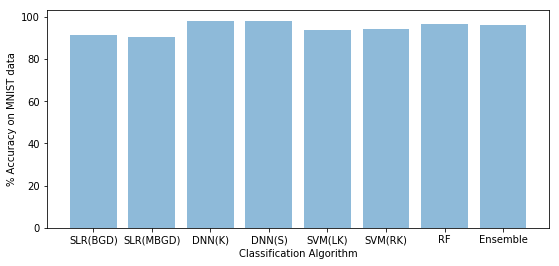

In [3]:
%matplotlib inline
l = [91.34, 90.43, 98.22, 97.86, 93.9, 94.35, 96.82, 96.17]
a = ['SLR(BGD)','SLR(MBGD)','DNN(K)','DNN(S)','SVM(LK)','SVM(RK)','RF','Ensemble']
fig= plt.figure(figsize=(9,4))
plt.bar(a,l, align='center', alpha=0.5)
plt.ylabel('% Accuracy on MNIST data')
plt.xlabel('Classification Algorithm')

Text(0.5, 0, 'Classification Algorithm')

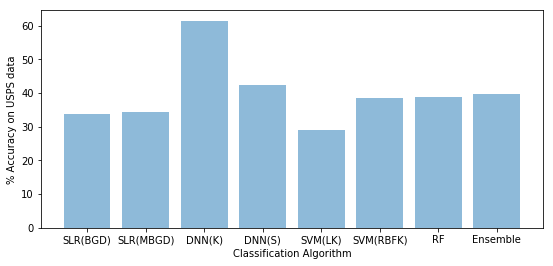

In [4]:
%matplotlib inline
l = [33.90, 34.39, 61.5, 42.49, 29.12, 38.53, 38.86, 39.75]
a = ['SLR(BGD)','SLR(MBGD)','DNN(K)','DNN(S)','SVM(LK)','SVM(RBFK)','RF','Ensemble']
fig= plt.figure(figsize=(9,4))
plt.bar(a,l, align='center', alpha=0.5)
plt.ylabel('% Accuracy on USPS data')
plt.xlabel('Classification Algorithm')